<center><h1>U-Net for Semantic Segmentation on Indian Driving Dataset</h1></center>

### Installing required modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from numpy import asarray,zeros,moveaxis
from tensorflow.keras.initializers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from sys import getsizeof
from tensorflow.keras.callbacks import TensorBoard
from tqdm import tqdm_notebook,tqdm
from sklearn.metrics import *
import os,sys,ntpath,fnmatch,shutil,cv2
import joblib,os.path,itertools,warnings
from tensorflow.keras.models import load_model 
from scipy.sparse import csc_matrix
import numpy as np
import pandas as pd
from os import path
!pip install import_ipynb
from IPython.display import clear_output
from time import time
np.random.seed(0)
from google.colab import drive
drive.mount('/content/drive')
! cp -v "/content/drive/My Drive/ColabIID_Files/Utility_Functions.ipynb" "/content" 
! cp -v "/content/drive/My Drive/IID_Files/Final.ipynb" "/content" 
! cp -v "/content/drive/My Drive/IID_Files/IID_Data_Prep_Utils1.ipynb" "/content"  
warnings.filterwarnings("ignore")
clear_output()

### Importing Data Preparation Modules

In [ ]:
import import_ipynb 
from Utility_Functions import *
from Final import *
from IID_Data_Prep_Utils1 import *

SyntaxError: ignored

### General Utility Function for Prediction

In [ ]:
def predict_for(data_for_prediction, weights_save_path=False):
    
    """  General Function to perform prediction for the specified data split  """
    
    Mean_MIoU, Accuracy, cf_matrix=[], [], np.zeros((7,7))
    x, y = Load_For_Prediction(data_for_prediction)
    Model, Skip = Select_Model(weights_save_path), 2
    
    for d in tqdm_notebook(range(0,len(x),Skip)):

        if (d>=(len(x)-Skip)): 
            plot,_,_=True,clear_output(),print("Total number of samples in {0} : {1}".format(data_for_prediction,len(x)))
        else: plot=False
        
        Miou, cf_matrix, Accuracy=Function_2(x[d:d+Skip],y[d:d+Skip],Mean_MIoU,cf_matrix,Accuracy,Model,plot,False,False,False)
    collected = gc.collect()
    
    return Miou, Accuracy, cf_matrix

### Implementation of U-Net

In [ ]:
def Unet_Segmentation(input_shape, n_classes):      

    """
    Function to build U-Net Architecture for Image Segmentation
    Input  : input_shape <tuple>, n_classes <Int>
    Return : Unet_model """

    def Unet_En_Blocks(Block_Number, Name, Filters, Kernel_Size, Pool_size, Previous_layer, initialize="he_normal"):

        """
        Function to Build U-Net Encoder Blocks 
        Input  : Block_Number <Int>, Name <String>, Filters <Int>, Kernel_Size <Tuple>,  Pool_size <Tuple>, Previous_layer <Keras.layer>, initialize <String>
        Return : Convolution2 <Keras.layer> """

        # Defining Max-pooling layer for each Encoder Block
        MaxPool = tf.keras.layers.MaxPooling2D(pool_size=Pool_size, name= Name+"_Maxpool")(Previous_layer) if Block_Number>1 else Previous_layer
        
        # Defining two Convolution layers for each Encoder Block
        Convolution1 = tf.keras.layers.Conv2D(Filters, Kernel_Size, name= Name+"_Conv1", activation = 'relu', kernel_initializer= initialize, padding='same')(MaxPool)
        Convolution2 = tf.keras.layers.Conv2D(Filters, Kernel_Size, name= Name+"_Conv2", activation = 'relu', kernel_initializer= initialize, padding='same')(Convolution1)
        
        return Convolution2
 
    def Unet_Dec_Blocks(Block_Number, Name, Filters, Kernel_Size, Previous_layer, Layer_to_Concatenate, initialize="he_normal"):

        """
        Function to Build U-Net Decoder Blocks 
        Input  : Block_Number <Int>, Name <String>, Filters <Int>, Kernel_Size <Tuple>, Previous_layer <Keras.layer>,  Layer_to_Concatenate <Keras.layer>,  initialize <String>
        Return : Convolution2 <Keras.layer> """


        # Defining Up-Convolution layers for Decoder Blocks
        Up_Sample = tf.keras.layers.UpSampling2D(size=(2, 2), name= Name+"_Upsample")(Previous_layer)
        Up_Convolution = tf.keras.layers.Conv2D(Filters,(2,2), name= Name+"_UpConv", activation = 'relu', padding = 'same',kernel_initializer=initialize)(Up_Sample)
        
        # concatenating feature maps that are copied from encoder block with Previous Layer
        Concatenated_Layer=tf.keras.layers.Concatenate(axis=3, name= Name+"_Concat")([Layer_to_Concatenate,Up_Convolution])   

        # Defining two Convolution layers for each Decoder Block     
        Convolution1 = tf.keras.layers.Conv2D(Filters, Kernel_Size, name= Name+"_Conv1", activation = 'relu', kernel_initializer= initialize, padding ='same')(Concatenated_Layer)
        Convolution2 = tf.keras.layers.Conv2D(Filters, Kernel_Size, name= Name+"_Conv2", activation = 'relu', kernel_initializer= initialize, padding ='same')(Convolution1)
        
        if Block_Number==4:

            # Final Convolution layer has number of classes as filter size followed by softmax    
            Convolution3 = tf.keras.layers.Conv2D(n_classes, Kernel_Size, name= "Final_Conv", activation = 'relu', kernel_initializer= initialize, padding ='same')(Convolution2)
            Output=Activation('softmax', name="Softmax")(Convolution3)
            
            return Output
        
        return Convolution2

    # Input Layer of U-Net
    Input_layer = tf.keras.layers.Input(shape=input_shape)

    # Building Encoder Block for U-Net Various filters Sizes 
    En_Block1 = Unet_En_Blocks(1, "En_Block1", 64,  (3,3), (2,2), Input_layer)
    En_Block2 = Unet_En_Blocks(2, "En_Block2", 128, (3,3), (2,2), En_Block1)
    En_Block3 = Unet_En_Blocks(3, "En_Block3", 256, (3,3), (2,2), En_Block2)
    En_Block4 = Unet_En_Blocks(4, "En_Block4", 512, (3,3), (2,2), En_Block3)
    En_Block5 = Unet_En_Blocks(5, "En_Block5", 1024, (3,3), (2,2), En_Block4)

    # Building Decoder Block for U-Net Various filters Sizes 
    Dec_Block1 = Unet_Dec_Blocks(1, "Dec_Block1", 512,  (3,3), En_Block5, En_Block4)
    Dec_Block2 = Unet_Dec_Blocks(2, "Dec_Block2", 256, (3,3), Dec_Block1, En_Block3)
    Dec_Block3 = Unet_Dec_Blocks(3, "Dec_Block3", 128, (3,3), Dec_Block2, En_Block2)
    Output_layer = Unet_Dec_Blocks(4, "Dec_Block4", 64, (3,3), Dec_Block3, En_Block1)
 
    # Invoke Model to get U-Net model 
    Unet_model = Model(Input_layer, Output_layer)
    
    return Unet_model

# Invoke Unet_Segmentation to get U-Net model  
input_shape, n_classes = (240, 480,3), 7
Unet = Unet_Segmentation(input_shape, n_classes)

### Training U-Net Model

In [ ]:
# Get current Time
start_time = time()

# Defining Batch size and epoch 
batch_size, epochs = 16, 50

# Defining tensorboard to store Training Information and filepath to store Unet model 
tensorboard, filepath = TensorBoard(log_dir=root+"logs/unet_{}".format(str(time())[5:10])),root+"/Unet.best.hdf5"

# Defining steps_per_epoch and validation_steps for Training
steps_per_epoch,validation_steps=int((len(train_img_files1)+len(train_img_files2))/batch_size),int((len(val_img_files1)+len(val_img_files2))/batch_size)

# Compile U-net Model
Unet.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'categorical_crossentropy',metrics = ['accuracy',miou])

# Defining EarlyStopping with patience=5 and monitor='val_miou'
es = EarlyStopping(monitor='val_miou', mode='max', verbose=1, patience=5)

# Defining ModelCheckpoint with monitor as 'val_miou'
checkpoint = ModelCheckpoint(filepath, monitor='val_miou', verbose=2, save_best_only=True, mode='max')

# Defining ReduceLROnPlateau to reduce learning rate with patience=3  
learning_rate_reduction = ReduceLROnPlateau(monitor='val_miou', patience=3, verbose=2, factor=0.2, min_lr=0.00001)

# Fit U-net Model to start training 
history=Unet.fit_generator(train_batch_generator(batch_size,epochs), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, validation_data=val_batch_generator(batch_size,epochs),
                            validation_steps=validation_steps, callbacks=[learning_rate_reduction,checkpoint,es,tensorboard])

# Printing Time taken for Training 
print("--- %s seconds ---" % (time() - start_time))

NameError: ignored

### U-Net Training Results

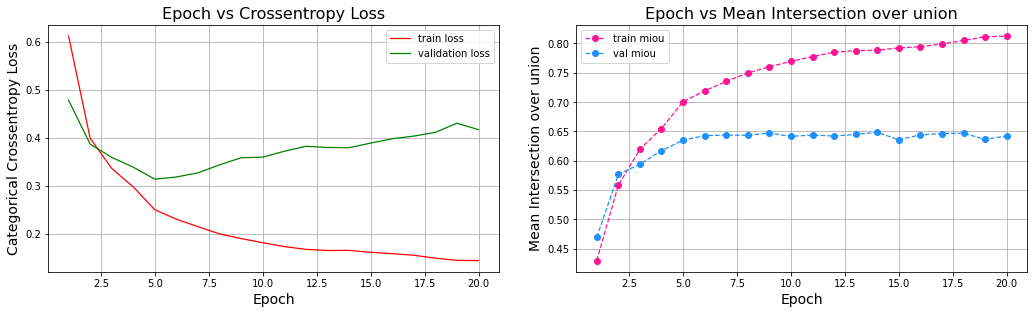

In [ ]:
# Training_result
plot_training_result(history)

* The Lowest value of Validation Categorical Crossentopy is 0.3134 which is at epoch-5 as above in the Graph.
* The Best Value of Validation Mean Intersection Over Union is 0.6484 which is at epoch-14 as above in the Graph.
* Keras callback ModelCheckpoint is used to save the best Model during Training to avoid overfitting.

### U-Net Prediction on Train Data

Total number of samples in Train_data : 10016

Few Segmentation Samples:>>>



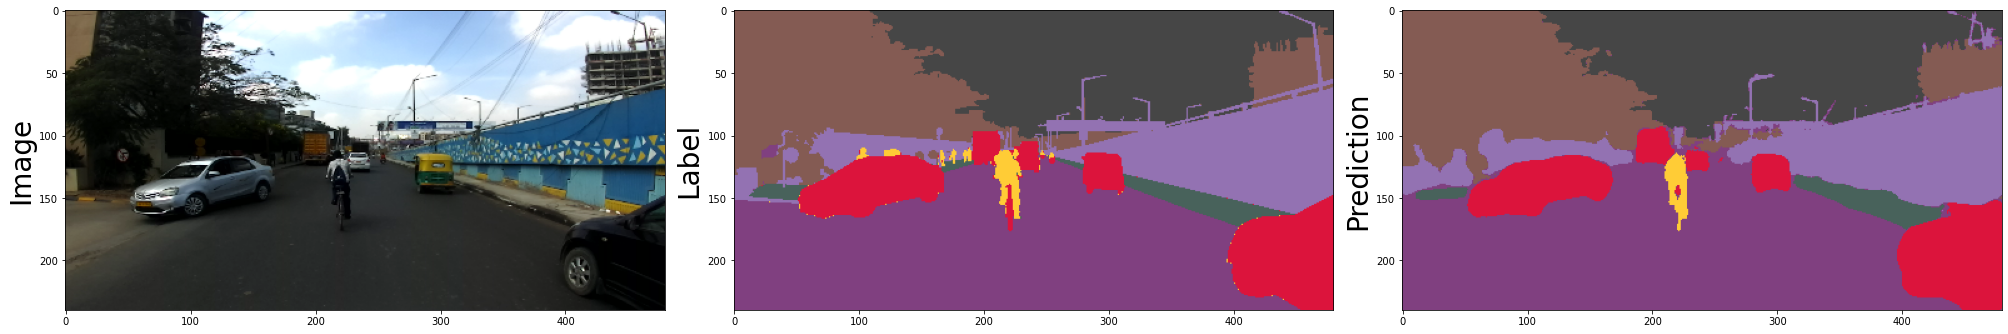

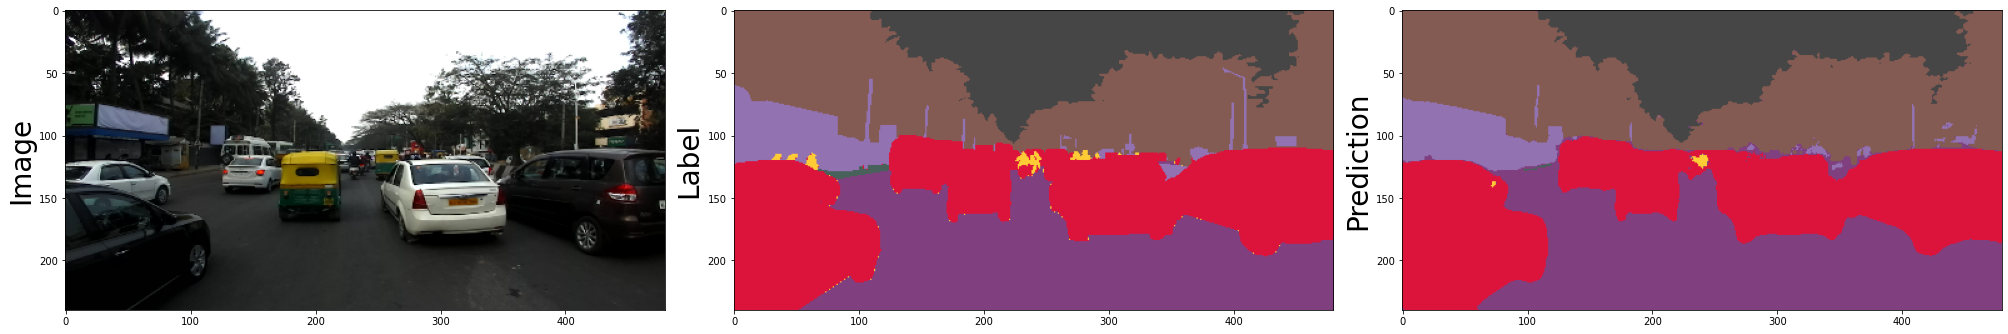


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.6642

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.9306

-----------------------
|  Confusion Matrix   |
-----------------------


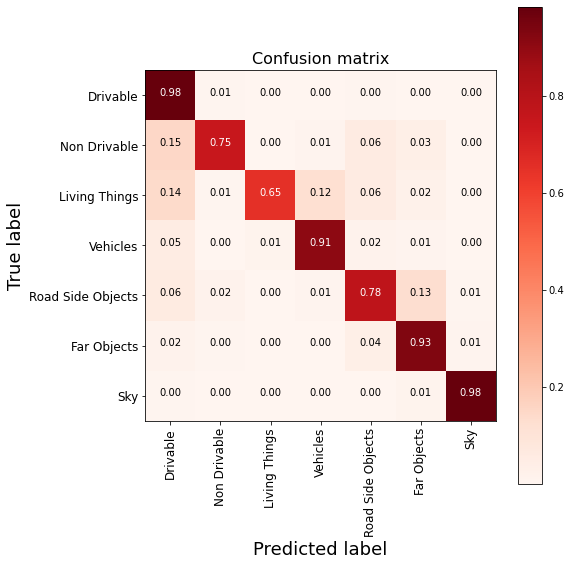

In [ ]:
# Train Prediction 
Miou, Accuracy, cf_matrix = predict_for("Train_data")

### U-Net Prediction on Validation Data

In [ ]:
# Validation Prediction 
Miou, Accuracy, cf_matrix = predict_for("Val_data")

NameError: ignored

### U-Net Prediction on Test Data

Total number of samples in Test_data : 4011

Few Segmentation Samples:>>>



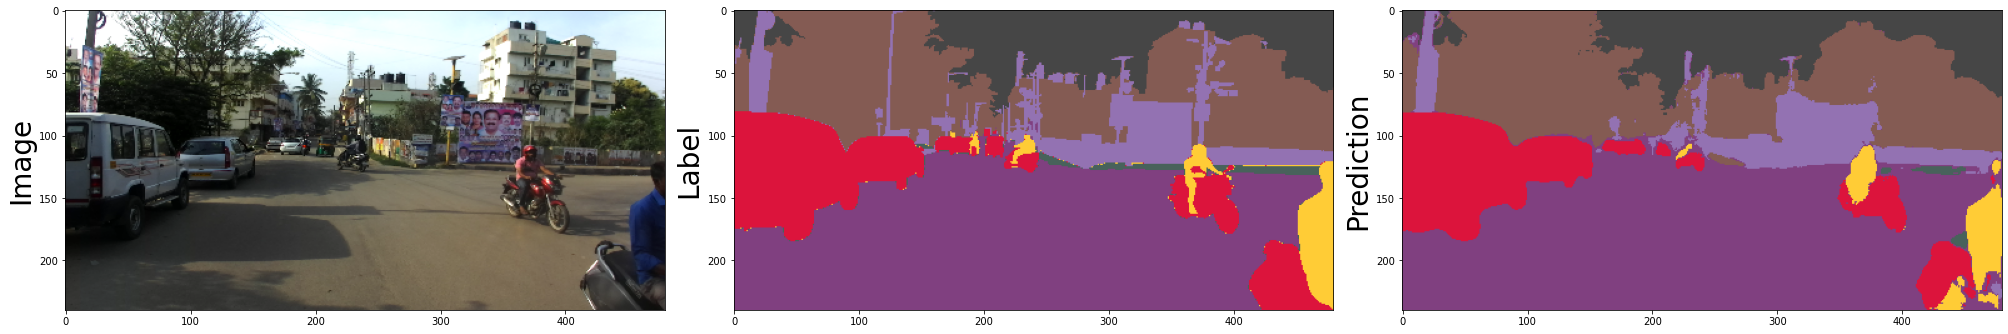


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.5979

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.8888

-----------------------
|  Confusion Matrix   |
-----------------------


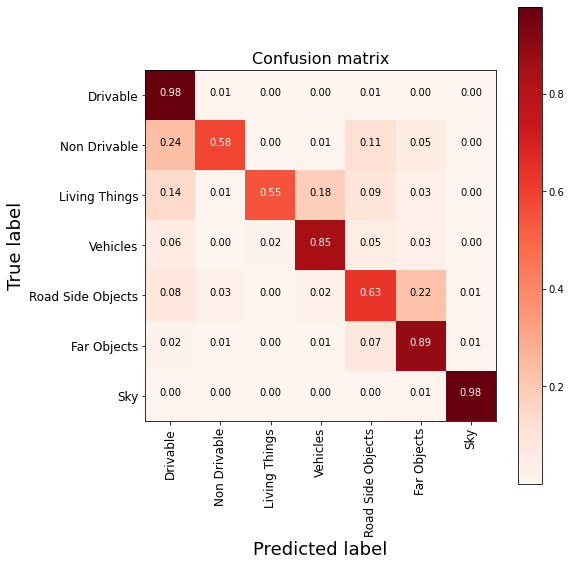

In [ ]:
# Test Prediction 
Miou, Accuracy, cf_matrix = predict_for("Test_data")

# Transfer Learning with U-Net

* Transfer learning refers to the process of using pre-trained model of one problem to solve other new second problem where the knowledge gained by pre-trained model is applied to solve a different but related problem.
*  The main advantages of Transfer learning are  saving training time, better performance of neural networks and no need for lot of data.
* Imagenet Pre-Trained Restnet50 with some alteration on U-Net is used below to solve the problem.

### Importing and Installing segmentation model package

In [ ]:
# reference: https://github.com/qubvel/segmentation_models
! pip install tensorflow==2.1.0
! pip install -U segmentation-models
import segmentation_models as sm
import tensorflow.keras
tensorflow.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `tf.keras` framework.


### Training Restnet50 + U-Net with Imagenet Pre-Trained weigths.

In [ ]:
start_time = time()
batch_size, epochs = 16, 50
model = sm.Unet('resnet50',classes=7,input_shape=(224, 480,3),activation='softmax')
tensorboard, filepath = TensorBoard(log_dir=root+"logs/unet_img_resnet50_nlrr{}".format(str(time())[:10])),root+"Unet_imgnet_resnet50_nlrr.hdf5"
steps_per_epoch,validation_steps=int((len(train_img_files1)+len(train_img_files2))/batch_size),int((len(val_img_files1)+len(val_img_files2))/batch_size)
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'categorical_crossentropy',metrics = ['accuracy',miou])
es = EarlyStopping(monitor='val_miou', mode='max', verbose=1, patience=5)
checkpoint = ModelCheckpoint(filepath, monitor='val_miou', verbose=2, save_best_only=True, mode='max')
history_tf=model.fit_generator(train_batch_generator(batch_size,epochs), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, validation_data=val_batch_generator(batch_size,epochs),
                            validation_steps=validation_steps, callbacks=[checkpoint,es,tensorboard])
print("--- %s seconds ---" % (time() - start_time))

Train for 876 steps, validate for 127 steps
Epoch 1/50
875/876 [============================>.] - ETA: 0s - loss: 0.5070 - accuracy: 0.8557 - miou: 0.5958
Epoch 00001: val_miou improved from -inf to 0.56564, saving model to /content/drive/My Drive/Unet_imgnet_resnet50_nlrr.hdf5
876/876 [==============================] - 552s 631ms/step - loss: 0.5067 - accuracy: 0.8558 - miou: 0.5959 - val_loss: 0.4781 - val_accuracy: 0.8363 - val_miou: 0.5656
Epoch 2/50
875/876 [============================>.] - ETA: 0s - loss: 0.2468 - accuracy: 0.9109 - miou: 0.7180
Epoch 00002: val_miou improved from 0.56564 to 0.66625, saving model to /content/drive/My Drive/Unet_imgnet_resnet50_nlrr.hdf5
876/876 [==============================] - 544s 621ms/step - loss: 0.2467 - accuracy: 0.9109 - miou: 0.7180 - val_loss: 0.2910 - val_accuracy: 0.8918 - val_miou: 0.6663
Epoch 3/50
875/876 [============================>.] - ETA: 0s - loss: 0.2024 - accuracy: 0.9255 - miou: 0.7545
Epoch 00003: val_miou improved fro

### Restnet50 + U-Net Training Results

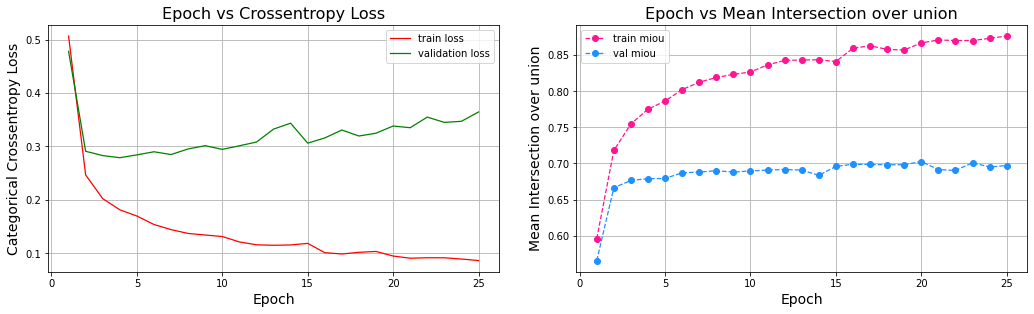

In [ ]:
# Training_result
plot_training_result(history_tf)

* The Lowest value of Validation Categorical Crossentopy is  0.2790 which is at epoch-4 as above in the Graph.
* The Best Value of Validation Mean Intersection Over Union is 0.7026 which is at epoch-20 as above in the Graph.

### Restnet50 + U-Net Prediction on Train Data

Total number of samples in Train_data : 10016

Few Segmentation Samples:>>>



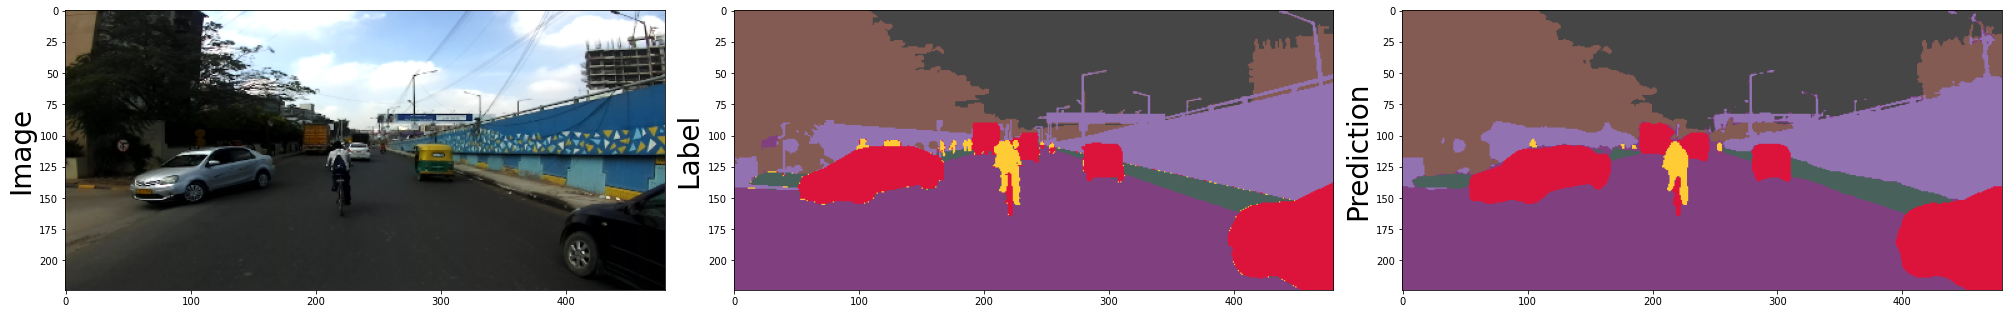

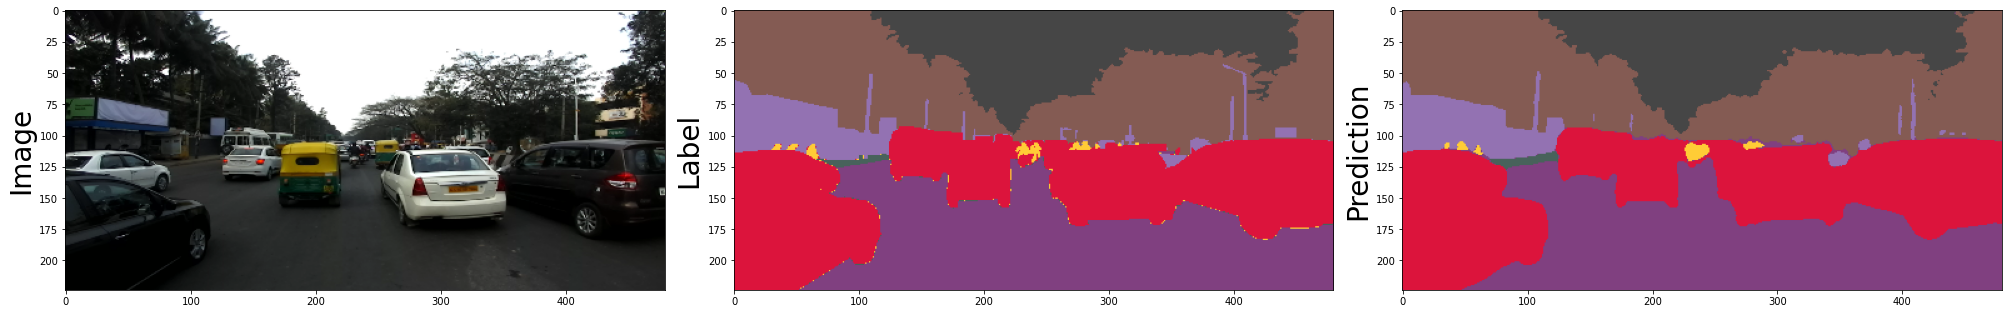


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.7487

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.96

-----------------------
|  Confusion Matrix   |
-----------------------


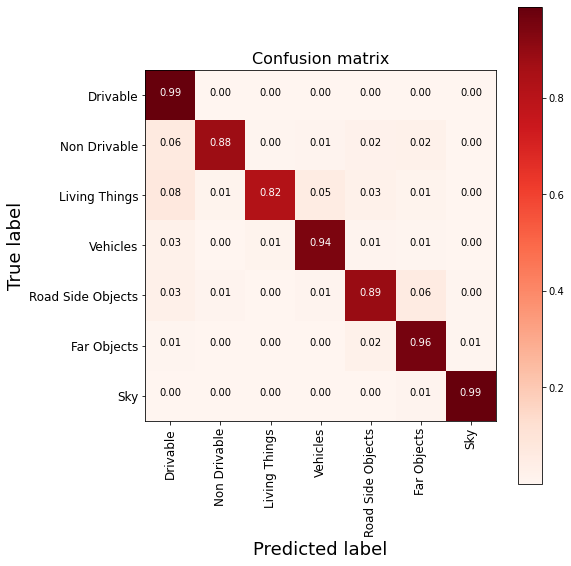

In [ ]:
Miou, Accuracy, cf_matrix = predict_for("Train_data","/content/drive/My Drive/Unet_imgnet_resnet50_nlrr.hdf5")

### Restnet50 + U-Net Prediction on Validation Data


Total number of samples in Test_data : 2036

Few Segmentation Samples:>>>



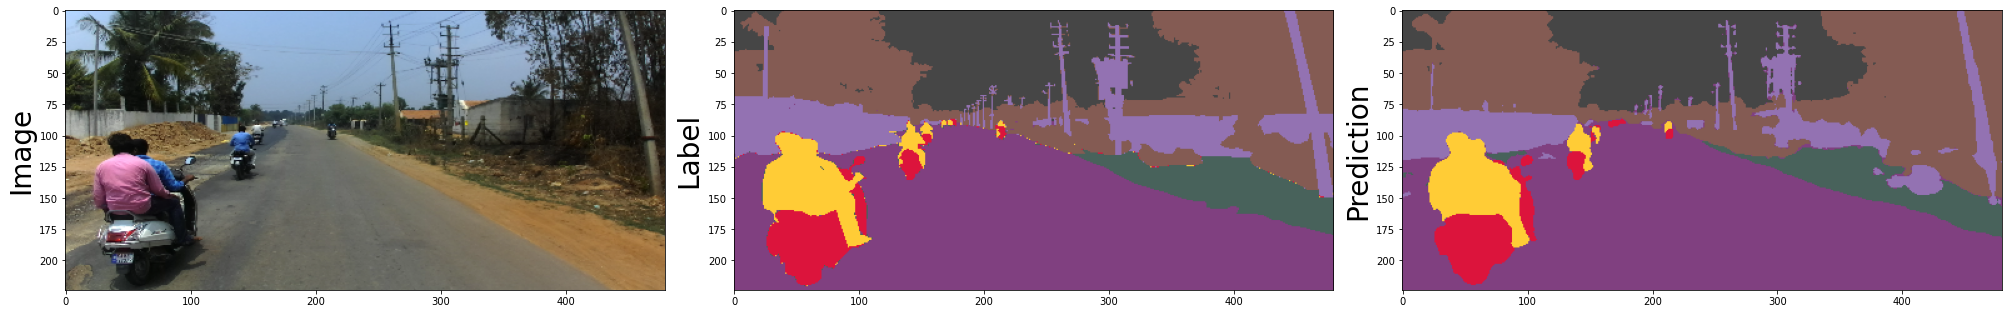

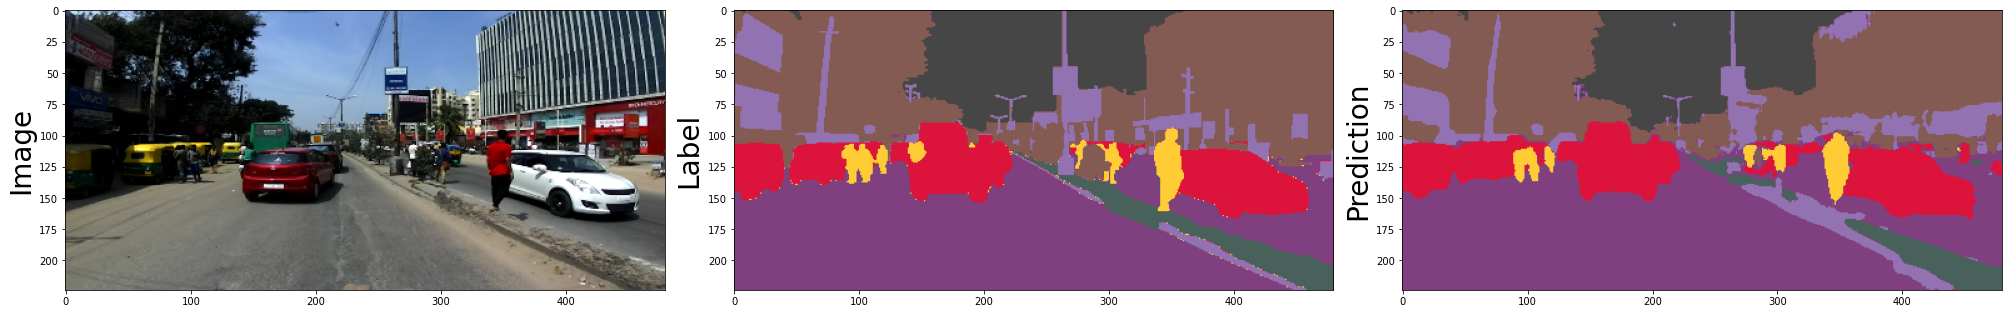


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.6389

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.9059

-----------------------
|  Confusion Matrix   |
-----------------------


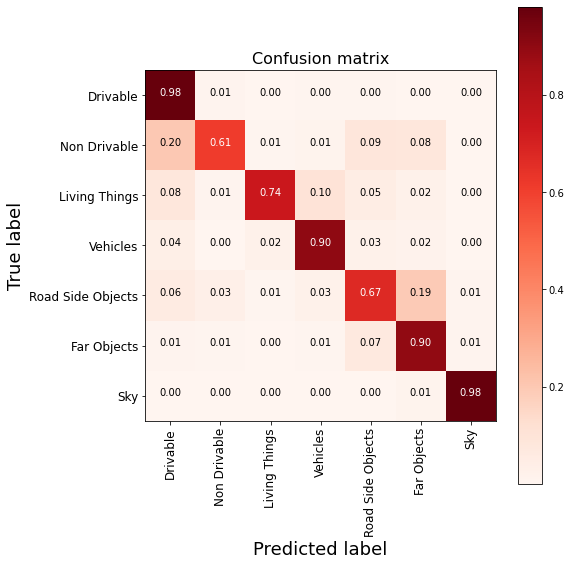

In [ ]:
Miou, Accuracy, cf_matrix = predict_for("Val_data","/content/drive/My Drive/IID_Files1/New_Model_logs_save/Unet_imgnet_resnet50_nlrr.hdf5")

### Restnet50 + U-Net Prediction on Test Data

Total number of samples in Test_data : 4011

Few Segmentation Samples:>>>



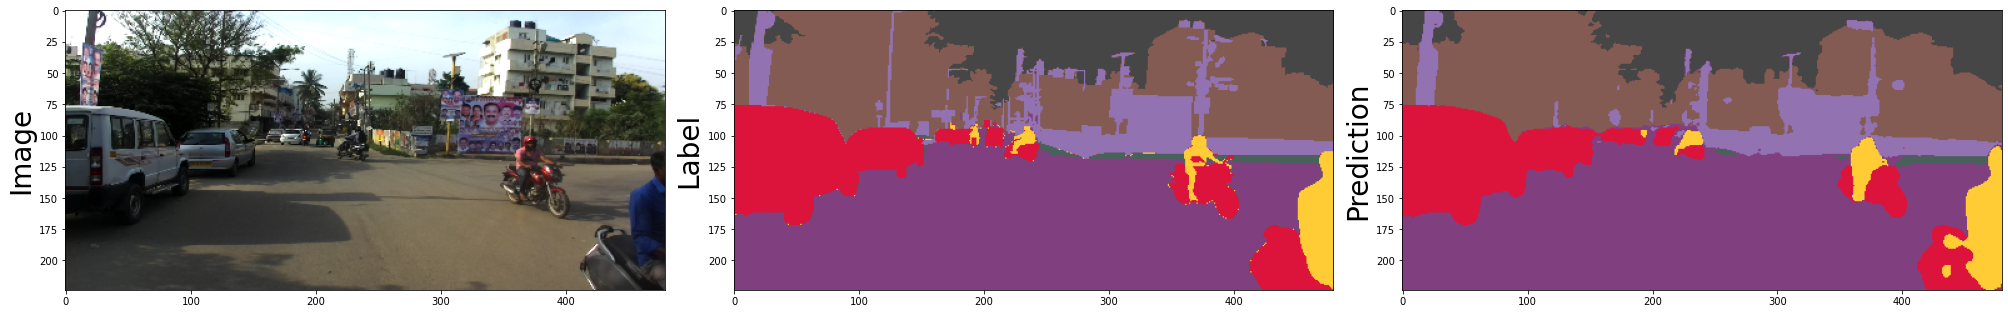


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.6496

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.916

-----------------------
|  Confusion Matrix   |
-----------------------


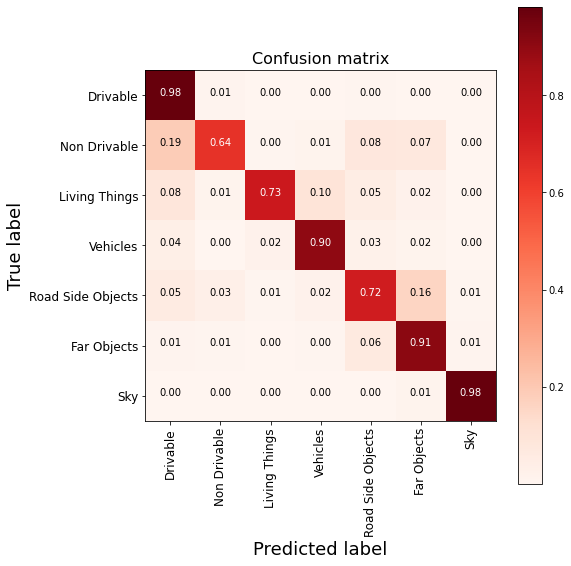

In [ ]:
Miou, Accuracy, cf_matrix = predict_for("Test_data","/content/drive/My Drive/IID_Files1/New_Model_logs_save/Unet_imgnet_resnet50_nlrr.hdf5")

### Pretty Tabel


In [ ]:
# https://ptable.readthedocs.io/en/latest/tutorial.html
print("\n\t     Performance Table-1")
from prettytable import PrettyTable
T1 = PrettyTable()
T1.field_names = ["U-Net","MIOU", "Accuracy"]
T1.add_row(["Train ","0.6642", "0.9306"])
T1.add_row([" ---------- ","----------","----------"])
T1.add_row(["Validation ","0.5843", "0.8760"])
T1.add_row([" ---------- ","----------","----------"])
T1.add_row(["Test ","0.5979", "0.8888"])
print(T1)

print("\n\t     Performance Table-2")
T2 = PrettyTable()
T2.field_names = ["Restnet50 + U-Net ","MIOU", "Accuracy"]
T2.add_row(["Train ","0.7487", "0.9600"])
T2.add_row([" ------------- ","----------","----------"])
T2.add_row(["Validation ","0.6389", "0.9059"])
T2.add_row([" ------------- ","----------","----------"])
T2.add_row(["Test ","0.6496", "0.9160"])
print(T2)


	     Performance Table-1
+--------------+------------+------------+
|    U-Net     |    MIOU    |  Accuracy  |
+--------------+------------+------------+
|    Train     |   0.6642   |   0.9306   |
|  ----------  | ---------- | ---------- |
| Validation   |   0.5843   |   0.8760   |
|  ----------  | ---------- | ---------- |
|    Test      |   0.5979   |   0.8888   |
+--------------+------------+------------+

	     Performance Table-2
+--------------------+------------+------------+
| Restnet50 + U-Net  |    MIOU    |  Accuracy  |
+--------------------+------------+------------+
|       Train        |   0.7487   |   0.9600   |
|   -------------    | ---------- | ---------- |
|    Validation      |   0.6389   |   0.9059   |
|   -------------    | ---------- | ---------- |
|       Test         |   0.6496   |   0.9160   |
+--------------------+------------+------------+


### <u>**Conclusion:**</u>
* The U-Net combines the information from the downsampling path and upsampling path to finally obtain general information.
* The Deep learning model has misclassified some of the labels between Diving, Non-Driving and Roadside Object, Far Object.
* Transfer Learning with some variation on U-Net achieves good performance on Image segmentation when compared to Basic U-net.
* More performance can be obtained by training Models with data in high resolution with more powerful hardware resources
